In [69]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)



### Dataset

In [70]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
dataloader_train_adam, dataloader_test_adam = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [71]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(4*4*128, 64),
        nn.ReLU(),
        nn.Linear(64,10),

        
        
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()
torch.random.manual_seed(0)
np.random.seed(0)
model_adam = create_model()

In [72]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [73]:
# Hyperparameters
learning_rate = .001
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.02)

#new optimizer
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

### Train model

In [74]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

trainer_adam = Trainer(
  model=model_adam,
  dataloader_train=dataloader_train_adam,
  dataloader_test=dataloader_test_adam,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_adam
)
train_loss_dict_adam, test_loss_dict_adam = trainer_adam.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:11<00:00, 79.43it/s]


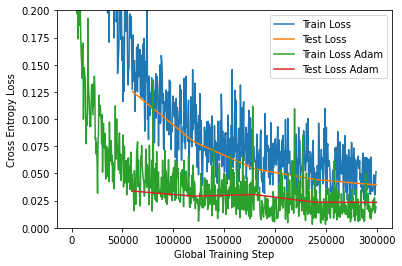

Final Test loss: 0.039415527882286534. Final Test accuracy: 0.9862
Final Test loss Adam: 0.023371381231016036. Final Test accuracy Adam: 0.9923


In [76]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")

utils.plot_loss(train_loss_dict_adam, label="Train Loss Adam")
utils.plot_loss(test_loss_dict_adam, label="Test Loss Adam")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .2])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()


final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

final_loss_adam, final_acc_adam = utils.compute_loss_and_accuracy(
    dataloader_test_adam, model_adam, loss_function)
print(f"Final Test loss Adam: {final_loss_adam}. Final Test accuracy Adam: {final_acc_adam}")